#**Unidade 02 Trabalho 02**

Alunos:
- Pablo Durkheim Fernandes do Nascimento
- Marta Maira Brito Barbosa

Sobre o projeto: é disponibilizado uma base de dados da Agência Nacional de Aviação (ANAC), a partir disso, temos que cumprir 05 requisitos que estão descritos mais abaixo. Como base, utilizamos as aplicações do NetworkX da semana 09 que é disponibilizado no github do professor Ivanovitch Medeiros.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os.path
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup

path = '/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/extract/'

# Flights (ANAC)
url = 'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Get all links
tags_a = soup.find_all('a', {
    'target': '_self',
    'class': 'internal-link',
})
links = [tag_a['href'] for tag_a in tags_a if tag_a['href'].endswith('.csv')]

# Download all files
for link in tqdm(links):
    filename = path + link.split('/')[-1]
    if os.path.exists(filename):
        continue

    file_response = requests.get(link)
    open(filename, 'wb').write(file_response.content)

# Public aerodromes (ANAC)
url = 'https://sistemas.anac.gov.br/dadosabertos/Aerodromos/Lista%20de%20aer%C3%B3dromos%20p%C3%BAblicos/AerodromosPublicos.csv'
file_response = requests.get(url)
open(path + 'public_aerodromes.csv', 'wb').write(file_response.content)

# Airport Codes (DataHub.io)
url = 'https://datahub.io/core/airport-codes/r/airport-codes.csv'
file_response = requests.get(url)
open(path + 'airport_codes.csv', 'wb').write(file_response.content)

100%|██████████| 24/24 [00:01<00:00, 21.12it/s]


6232459

In [ ]:
pip install geocoder

In [ ]:
#transform_to_airports_csv.py
import geocoder
import pandas as pd

path = '/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/extract/'

# ANAC dataset
anac_columns = [
    'origin_airport_abbreviation',
    'origin_airport_name',
    'origin_airport_state',
    'origin_airport_region',
    'origin_airport_country',
    'origin_airport_continent',
    'destination_airport_abbreviation',
    'destination_airport_name',
    'destination_airport_state',
    'destination_airport_region',
    'destination_airport_country',
    'destination_airport_continent',
]
df_anac = pd.read_csv('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/anac.csv', usecols=anac_columns)

# Get airports from ANAC
same_columns = {
    'origin_airport_abbreviation': 'code',
    'origin_airport_name': 'name',
    'origin_airport_state': 'state',
    'origin_airport_region': 'region',
    'origin_airport_country': 'country',
    'origin_airport_continent': 'continent',
    'destination_airport_abbreviation': 'code',
    'destination_airport_name': 'name',
    'destination_airport_state': 'state',
    'destination_airport_region': 'region',
    'destination_airport_country': 'country',
    'destination_airport_continent': 'continent',
}
origin_columns = [
    'origin_airport_abbreviation',
    'origin_airport_name',
    'origin_airport_state',
    'origin_airport_region',
    'origin_airport_country',
    'origin_airport_continent',
]
destination_columns = [
    'destination_airport_abbreviation',
    'destination_airport_name',
    'destination_airport_state',
    'destination_airport_region',
    'destination_airport_country',
    'destination_airport_continent',
]

df_origins = df_anac[origin_columns]
df_origins = df_origins.rename(columns=same_columns)

df_destinations = df_anac[destination_columns]
df_destinations = df_destinations.rename(columns=same_columns)

df_airports = pd.concat([df_origins, df_destinations])
df_airports = df_airports.drop_duplicates()

# Airfields dataset
airfields_columns = [
    'Código OACI',
    'LATGEOPOINT',
    'LONGEOPOINT',
]
df_airfields = pd.read_csv(path + 'public_aerodromes.csv',
                           sep=';',
                           usecols=airfields_columns,
                           skiprows=1,
                           encoding='ISO-8859-1')

# Rename columns
columns_map = {
    'CÓDIGO OACI': 'code',
    'LATGEOPOINT': 'lat_geo_point',
    'LONGEOPOINT': 'lon_geo_point',
}
df_airfields = df_airfields.rename(columns=columns_map)

# Others airports
others_airports_columns = [
    'ident',
    'coordinates',
]
df_others_airports = pd.read_csv(path + 'airport_codes.csv', usecols=others_airports_columns)

# Rename columns
columns_map = {
    'ident': 'code',
}
df_others_airports = df_others_airports.rename(columns=columns_map)
df_others_airports[['lon_geo_point', 'lat_geo_point']] = df_others_airports.coordinates.str.split(', ', expand=True, )
df_others_airports = df_others_airports.drop(columns=['coordinates'])

# Coordinates dataframe
df_coordinates = pd.concat([df_airfields, df_others_airports])

# Merge dataframe
df_merge = pd.merge(
    df_airports,
    df_coordinates,
    how='left',
    left_on='code',
    right_on='code')
df_merge = df_merge.dropna(how='all')
df_merge = df_merge.drop_duplicates('code')

# Find the others geolocations
columns = [
    'name',
    'state',
    'region',
    'country',
    'continent',
]
airports_to_find = []
for index, row in df_merge[df_merge.lat_geo_point.isnull()].iterrows():
    label = ''

    for column in columns:
        if type(row[column]) == str and row[column]:
            label += row[column] + ', '

    if not label:
        continue

    geo_result = geocoder.arcgis(label[:-2])
    df_merge.loc[df_merge.code == row['code'], 'lat_geo_point'] = geo_result.latlng[0]
    df_merge.loc[df_merge.code == row['code'], 'lon_geo_point'] = geo_result.latlng[1]

# Save result
df_merge.to_csv('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/airports.csv', index=False, encoding='utf-8')

In [ ]:
#transform_to_anac_csv.py
import glob
import pandas as pd

files = glob.glob('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/extract/resumo_anual_*.csv')

# Combine all files in the list
combined_csv = pd.concat([pd.read_csv(file, sep=';', encoding='ISO-8859-1') for file in files])

# Rename columns
columns_map = {
    'EMPRESA (SIGLA)': 'company_abbreviation',
    'EMPRESA (NOME)': 'company_name',
    'EMPRESA (NACIONALIDADE)': 'company_nationality',
    'ANO': 'year',
    'MÊS': 'month',
    'AEROPORTO DE ORIGEM (SIGLA)': 'origin_airport_abbreviation',
    'AEROPORTO DE ORIGEM (NOME)': 'origin_airport_name',
    'AEROPORTO DE ORIGEM (UF)': 'origin_airport_state',
    'AEROPORTO DE ORIGEM (REGIÃO)': 'origin_airport_region',
    'AEROPORTO DE ORIGEM (PAÍS)': 'origin_airport_country',
    'AEROPORTO DE ORIGEM (CONTINENTE)': 'origin_airport_continent',
    'AEROPORTO DE DESTINO (SIGLA)': 'destination_airport_abbreviation',
    'AEROPORTO DE DESTINO (NOME)': 'destination_airport_name',
    'AEROPORTO DE DESTINO (UF)': 'destination_airport_state',
    'AEROPORTO DE DESTINO (REGIÃO)': 'destination_airport_region',
    'AEROPORTO DE DESTINO (PAÍS)': 'destination_airport_country',
    'AEROPORTO DE DESTINO (CONTINENTE)': 'destination_airport_continent',
    'NATUREZA': 'nature',
    'GRUPO DE VOO': 'flight_group',
    'PASSAGEIROS PAGOS': 'paid_passenger',
    'PASSAGEIROS GRÁTIS': 'free_passenger',
    'CARGA PAGA (KG)': 'charge_paid_kg',
    'CARGA GRÁTIS (KG)': 'charge_free_kg',
    'CORREIO (KG)': 'mail_kg',
    'ASK': 'ask',
    'RPK': 'rpk',
    'ATK': 'atk',
    'RTK': 'rtk',
    'COMBUSTÍVEL (LITROS)': 'fuel_l',
    'DISTÂNCIA VOADA (KM)': 'distance_flown_km',
    'DECOLAGENS': 'takeoffs',
    'CARGA PAGA KM': 'charge_paid_km',
    'CARGA GRATIS KM': 'charge_free_km',
    'CORREIO KM': 'mail_km',
    'ASSENTOS': 'seats',
    'PAYLOAD': 'payload',
    'HORAS VOADAS': 'fly_hours',
    'BAGAGEM (KG)': 'baggage_kg',
}
combined_csv = combined_csv.rename(columns=columns_map)

# Export to csv
combined_csv.to_csv('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/anac.csv', index=False, encoding='utf-8')

In [ ]:
#transform_to_graphml.py
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

df_airports = pd.read_csv('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/airports.csv')
df_flights = pd.read_csv('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/anac.csv')

# Create graph
G = nx.Graph()

# Add nodes
for index, row in df_airports.iterrows():
    G.add_node(row['code'],
               name=row['name'],
               state=row["state"],
               region=row["region"],
               country=row['country'],
               latitude=row['lat_geo_point'],
               longitude=row['lon_geo_point']
               )

# Add edges
df_edges = df_flights[[
    'origin_airport_abbreviation',
    'destination_airport_abbreviation',
]].dropna()
df_edges = df_edges.groupby(df_edges.columns.tolist(), as_index=False).size()
for index, row in df_edges.iterrows():
    if row['origin_airport_abbreviation'] == row['destination_airport_abbreviation']:
        continue
    G.add_edge(row['origin_airport_abbreviation'], row['destination_airport_abbreviation'], flight_count=row['size'])

# Export to graphml
nx.write_graphml(G, '/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/air_traffic.graphml')

"""
# Plota o grafo
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'flight_count')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Grafo de tráfego aéreo')
plt.show()

"""

In [ ]:
!pip install nxviz

In [ ]:
# import usefull packages
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import nxviz as nv
import seaborn as sns

G = nx.read_graphml('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/air_traffic.graphml')

print("A rede possui {} nós e {} arestas".format(G.number_of_nodes(),
                                                     G.number_of_edges()))

A rede possui 1124 nós e 10132 arestas


In [ ]:
# Just look how the nodes are represented in the Network
G.nodes(data=True)

#**REQUISITO 1**

Realize um estudo sobre a assortatividade da rede, considerando a REGIÃO onde o aeroporto está localizado como um atributo. Gere um gráfico estático e um gráfico interativo semelhantes aos utilizados em sala de aula, levando em consideração a REGIÃO do aeroporto.

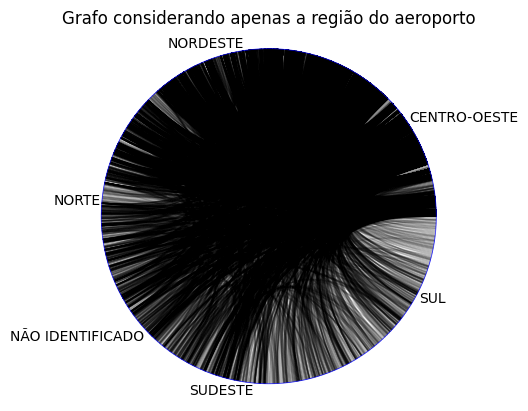

Coeficiente de assortatividade de atributos: 0.16359258302089089


In [ ]:
import matplotlib.pyplot as plt
from nxviz import annotate, highlights
from random import choice

G = nx.read_graphml('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/air_traffic.graphml')

ax = nv.circos(G)
annotate.circos_group(G, group_by="region")

# Save figure
plt.savefig("/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/imagens/grafo_regiao_completo.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=False)

# Display graph
plt.title('Grafo considerando apenas a região do aeroporto')
plt.show()
#nx.degree_assortativity_coefficient(G)
assortatividade = nx.attribute_assortativity_coefficient(G, "region")
print("Coeficiente de assortatividade de atributos:", assortatividade)

#print(nx.attribute_mixing_matrix(G, "region"))

Analisando a homofilia pela assortatividade, vemos graficamente que há concentrações fortes na parte do Nordeste e Centro-Oeste em direção ao centro, enquanto a região Sul é menos escura. Utilizando NetworkX, o grau da assortatividade em relação ao atributo "region" é maior que zero, não significa necessariamente que a rede é assortativa, mas os nós de graus maiores tem uma tendência para se conectar com nós de graus maiores.

Obs.: nem sempre o atributo "region" está preenchido nos dados fornecidos, nessa plotagem em específico consideramos estes campos não preenhcidos, por isso tem a opção "NÃO IDENTIFICADO", se retirarmos os campos não preenchidos a rede passa a ser disassortativa.

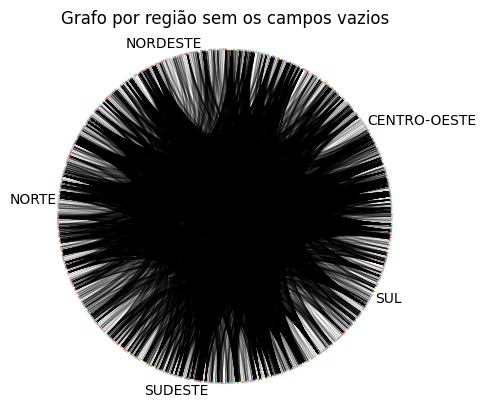

Coeficiente de assortatividade de grau: -0.19605264855558172


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv
from nxviz import CircosPlot, annotate, highlights

G = nx.read_graphml('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/air_traffic.graphml')

# Lista com as regiões desejadas
regioes = ["NORDESTE", "NORTE", "CENTRO-OESTE", "SUL", "SUDESTE"]

# Filtra os nós com os atributos de região desejados
nodes_regioes = [node for node, region in G.nodes(data='region') if region in regioes]

# Cria um subgrafo com os nós selecionados
subgraph = G.subgraph(nodes_regioes)

ax = nv.circos(subgraph, node_color_by="region",)
annotate.circos_group(subgraph, group_by="region")

# Configurações do gráfico
plt.title('Grafo por região sem os campos vazios')
plt.savefig("/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/imagens/grafo_regiao_completo_sem_vazio.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=False)
plt.show()

r = nx.degree_assortativity_coefficient(subgraph, "region")
print("Coeficiente de assortatividade de grau:", r)

#assortatividade = nx.attribute_assortativity_coefficient(subgraph, "region")
#print("Coeficiente de assortatividade de atributos :", assortatividade)

#print(subgraph.nodes(data=True))

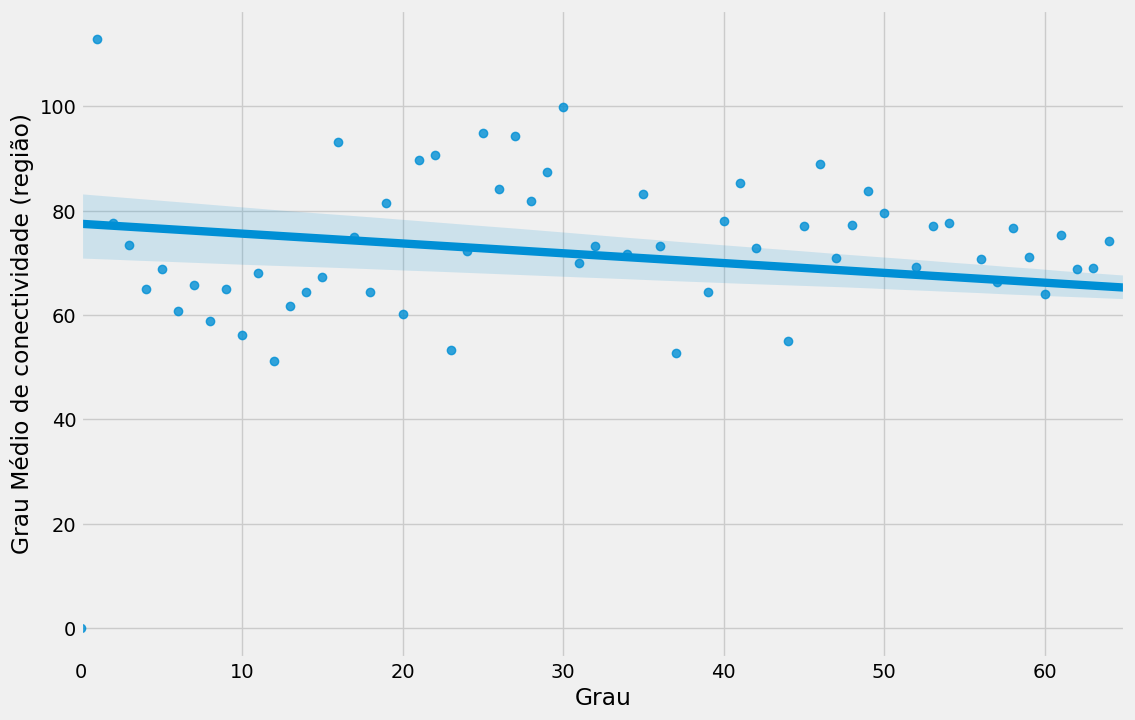

Coeficiente de assortatividade de grau: -0.19605264855558172


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from nxviz import CircosPlot

# Lista com as regiões desejadas
regioes = ["NORDESTE", "NORTE", "CENTRO-OESTE", "SUL", "SUDESTE"]

# Filtra os nós com os atributos de região desejados
nodes_regioes = [node for node, region in G.nodes(data='region') if region in regioes]

# Cria um subgrafo com os nós selecionados
subgraph = G.subgraph(nodes_regioes)

# average degree of neighbors
degree, avg_neigh_degree = zip(*nx.average_degree_connectivity(subgraph).items())

# convert to list
degree = list(degree)
avg_neigh_degree = list(avg_neigh_degree)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree,y=avg_neigh_degree,ax=ax)

ax.set_xlabel("Grau")
ax.set_ylabel("Grau Médio de conectividade (região)")
ax.set_xlim(0,65)

# Save figure
plt.savefig("/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/imagens/grafo_iterativo_region.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=False)

plt.show()

r = nx.degree_assortativity_coefficient(subgraph)
print("Coeficiente de assortatividade de grau:", r)

Nesse caso, fizemos o gráfico em relação as regiões e retiramos os casos em que o atributo "region" está vazio, plotamos e verificamos que a rede tem uma inclinação para baixo, ou seja, graus maiores tendem a se conectar com graus menores, característica de uma rede disassortativa. Utilizamos a métrica "r" mostrada no vídeo disponibilizado pelo professor para confirmar o fato observado, vimos que o valor é de fato negativo.

#**REQUISITO 2**

Realize uma análise bivariada entre o grau do vértice e o número médio de vizinhos. Crie um gráfico semelhante considerando a rede brasileira e todas as suas regiões (Norte, Nordeste, Sul, Sudeste e Centro-Oeste). Relate suas principais descobertas.

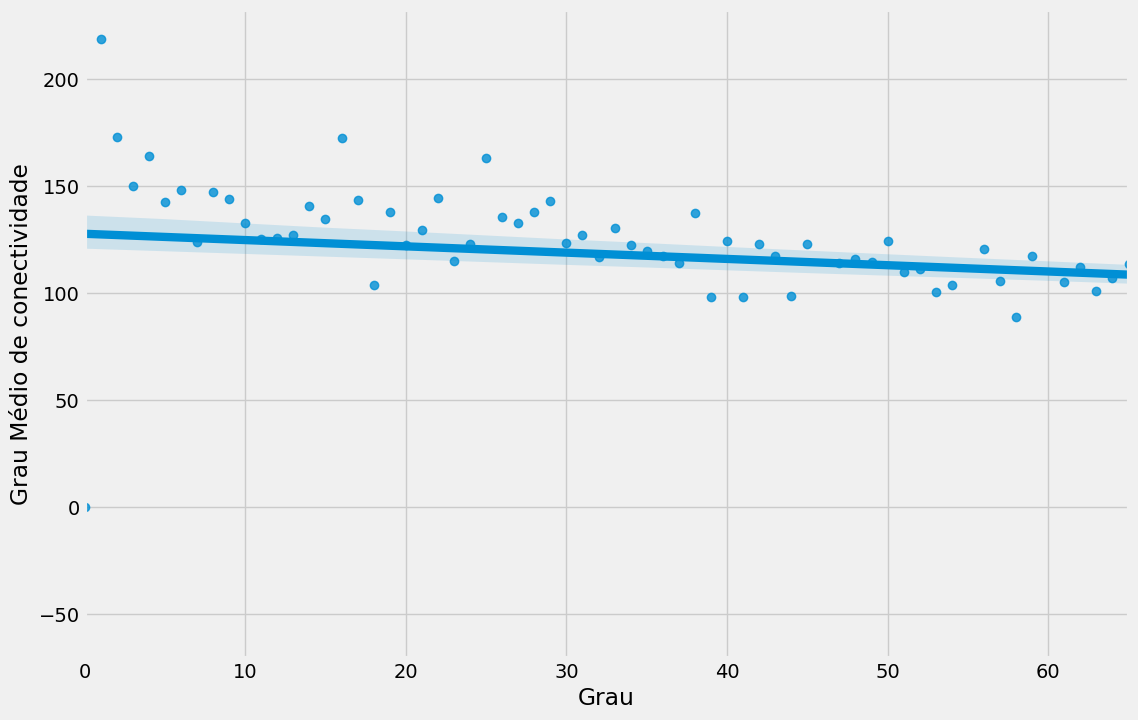

Coeficiente de assortatividade de grau: -0.26887610746360635


In [ ]:
# average degree of neighbors
degree, avg_neigh_degree = zip(*nx.average_degree_connectivity(G).items())

# convert to list
degree = list(degree)
avg_neigh_degree = list(avg_neigh_degree)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree,y=avg_neigh_degree,ax=ax)

ax.set_xlabel("Grau")
ax.set_ylabel("Grau Médio de conectividade")
ax.set_xlim(0,65)

# Save figure
plt.savefig("/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/imagens/grafo_completo2.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=False)

plt.show()

#nx.degree_assortativity_coefficient(G)
r = nx.degree_assortativity_coefficient(G)
print("Coeficiente de assortatividade de grau:", r)

Para a analise bivariada entre o grau do vértice e o nº médio de vizinhos, plotamos o gráfico semelhante ao gráfico anterior, mas dessa vez, considerando toda a população de dados. Vemos uma semelhança ao gráfico anterior, com inclinação para baixo, tendendo a ser disassortativo. Utilizamos a métrica "R" (grau de correlação) para verificarmos se estava entre -1 e 0, e de fato está.

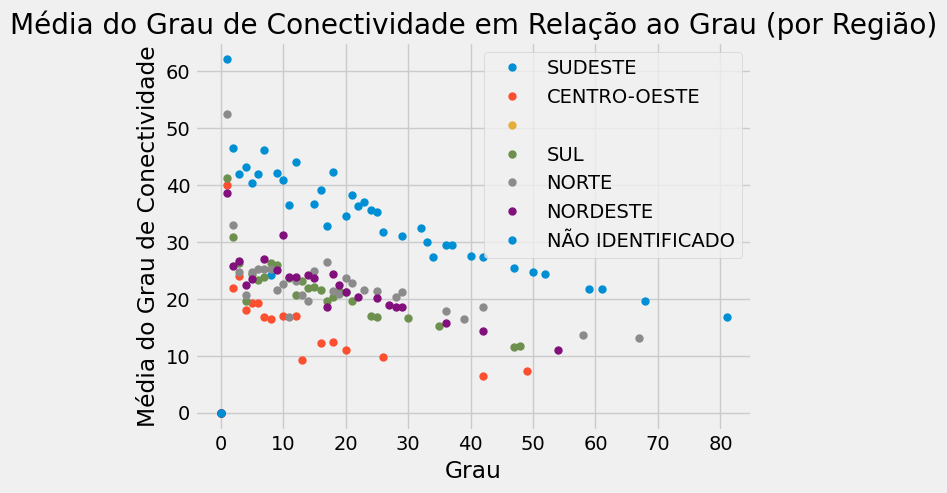

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Cria o grafo
G = nx.read_graphml('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/air_traffic.graphml')

# Calcula as médias de grau de conectividade por região
avg_degree_connectivity_by_region = {}
regions = nx.get_node_attributes(G, 'region')
unique_regions = set(regions.values())

for region in unique_regions:
    nodes_in_region = [node for node, attr in regions.items() if attr == region]
    if len(nodes_in_region) > 0:
        subgraph = G.subgraph(nodes_in_region)
        avg_degree_connectivity_by_region[region] = nx.average_degree_connectivity(subgraph)

# Plota o gráfico para cada região
for region, avg_degree_connectivity in avg_degree_connectivity_by_region.items():
    degree, avg_neigh_degree = zip(*avg_degree_connectivity.items())
    plt.plot(degree, avg_neigh_degree, 'o', markersize=5, label=region)
    #plt.scatter(degree, avg_neigh_degree, s=degree, label=region)
    #plt.scatter(degree, avg_neigh_degree, c='blue', edgecolors='black', linewidths=1, label=region)


    # Plota uma reta entre os pontos
    #plt.plot(degree, avg_neigh_degree, linestyle='--', color='gray')


# Save figure
plt.savefig("/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/imagens/grafico-estatistico.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=False)

# Configurações do gráfico
plt.xlabel('Grau')
plt.ylabel('Média do Grau de Conectividade')
plt.title('Média do Grau de Conectividade em Relação ao Grau (por Região)')
plt.legend()
plt.grid(True)
plt.show()


Relato das descobertas:

* Podemos perceber que todas as regiões seguem o mesmo padrão: enquanto o grau aumenta, a média de conectividade diminui. O que nos faz pensar que os aeroportos brasileiros com grande quantidade de voos tendem a ter viagens para outros aeroportos brasileiros com menos quantidades de voos que o atualmente comparado, e vice-versa, obviamente esse padrão não se aplica a todos.
* A região Sudeste aparece acima no gráfico em relação as outras regiões, o que nos faz pensar que em média, os aeroportos nessa região possuem menos conexões com outros aeroportos em comparação com a quantidade de conexões que seus vizinhos têm. Essa tendência pode indicar que, na região Sudeste, alguns aeroportos principais têm um alto grau de conexões, enquanto outros aeroportos têm um grau de conexões relativamente baixo.
* Já a região Centro-Oeste, apresenta uma média de conectividade mais baixa em relação às outras regiões, isso pode indicar que os aeroportos localizados nessa região possuem, em média, menos conexões com outros aeroportos.
* Norte, Nordeste e Sul, apresentam uma faixa intermediária entre a região Sudeste e Centro-Oeste

#**REQUISITO 3**

Determine quantos componentes conectados existem na rede aérea brasileira. Caracterize
cada componente: quantidade, porcentagem por região.

In [ ]:
# interact under all connected component of G
#for component in nx.connected_components(subgraph):
  #print(component)

print("\nNúmero de componentes conectados na rede aéria brasileira:", nx.number_connected_components(subgraph),"\n")

# Obter os nós do subgrafo
nodes = subgraph.nodes

#print(subgraph.nodes(data=True))


# Criar um dicionário para mapear as siglas de aeroporto às regiões
aeroportos_regioes = {}

#total de aeroportos nessas regioes
aero_nordeste = 0
aero_norte = 0
aero_sul = 0
aero_sudeste = 0
aero_centro_oeste = 0

# Percorrer os nós do subgrafo e associar a região correspondente a cada sigla de aeroporto
for node in nodes:
    sigla = node
    regiao = subgraph.nodes[node]['region']
    aeroportos_regioes[sigla] = regiao

    if(regiao == 'NORDESTE'):
      aero_nordeste += 1
    if(regiao == 'NORTE'):
      aero_norte += 1
    if(regiao == 'SUDESTE'):
      aero_sudeste += 1
    if(regiao == 'CENTRO-OESTE'):
      aero_centro_oeste += 1
    if(regiao == 'SUL'):
      aero_sul += 1
'''    
print(aero_nordeste)
print(aero_norte)
print(aero_sudeste)
print(aero_centro_oeste)
print(aero_sul)
print("A rede possui {} nós e {} arestas".format(subgraph.number_of_nodes(),
                                                     subgraph.number_of_edges())) '''
# Imprimir a informação de cada componente conectado com as respectivas regiões

for component in nx.connected_components(subgraph):
    
    aero_por_componente_nordeste = 0
    aero_por_componente_norte = 0
    aero_por_componente_sudeste = 0
    aero_por_componente_sul = 0
    aero_por_componente_centro_oeste = 0
    
    component_regioes = [aeroportos_regioes.get(sigla) for sigla in component]
    print("Componente:", component)
    print("Regiões:", component_regioes)
    total_aero_por_componente = list(component_regioes)
    print("Quantidade de aeroportos:", len(total_aero_por_componente) )

    for regiao in total_aero_por_componente:
      if(regiao == "NORDESTE"):
        aero_por_componente_nordeste += 1
      if(regiao == "NORTE"):
        aero_por_componente_norte += 1
      if(regiao == "CENTRO-OESTE"):
        aero_por_componente_centro_oeste += 1
      if(regiao == "SUL"):
        aero_por_componente_sul += 1
      if(regiao == "SUDESTE"):
        aero_por_componente_sudeste += 1

    per_nordeste = round((aero_por_componente_nordeste/len(total_aero_por_componente))*100, 2)
    per_norte = round((aero_por_componente_norte/len(total_aero_por_componente))*100, 2)
    per_centro_oeste = round((aero_por_componente_centro_oeste/len(total_aero_por_componente))*100, 2)
    per_sudeste = round((aero_por_componente_sudeste/len(total_aero_por_componente))*100, 2)
    per_sul = round((aero_por_componente_sul/len(total_aero_por_componente))*100, 2)

    print("Percentual da região nordeste:", per_nordeste,"% |", aero_por_componente_nordeste,"aeroportos de um total de", len(total_aero_por_componente), "neste componente.")
    print("Percentual da região norte:", per_norte,"% |", aero_por_componente_norte,"aeroportos de um total de", len(total_aero_por_componente), "neste componente.")
    print("Percentual da região centro-oeste:", per_centro_oeste,"% |", aero_por_componente_centro_oeste,"aeroportos de um total de", len(total_aero_por_componente), "neste componente.")
    print("Percentual da região sul:", per_sul,"% |", aero_por_componente_sul,"aeroportos de um total de", len(total_aero_por_componente), "neste componente.")
    print("Percentual da região sudeste:", per_sudeste,"% |", aero_por_componente_sudeste,"aeroportos de um total de", len(total_aero_por_componente), "neste componente.\n")



Número de componentes conectados na rede aéria brasileira: 6 

Componente: {'SDVE', 'SBKP', 'SWFE', 'SSSC', 'SWJP', 'SWJV', 'SDLU', 'SBRP', 'SBME', 'SBJC', 'SNWR', 'SWEE', 'SSOU', 'SNBV', 'SNCX', 'SNEB', 'SBUY', 'SWXM', 'SBVG', 'SNJB', 'SJKB', 'SNMX', 'SBRG', 'SWBG', '1AON', 'SBBU', 'SSTD', 'SDNM', 'SBTC', 'SNVB', 'SDJA', 'SBIZ', 'SNAV', 'SWPH', 'SWRP', 'SSPK', 'SNJM', 'SDMC', 'SSTL', 'SWGN', 'SBOI', 'SBSV', 'SBAC', 'SDRS', 'SBUL', 'SBPP', 'SBMI', 'SNQW', 'SWKQ', 'SWFN', 'SBFE', 'SWII', 'SBTE', 'SSKW', 'SBSP', 'SWEI', 'SWNO', 'SBTK', 'SSER', 'SBHT', 'SIGP', 'SBBE', 'SNRJ', 'SBSR', 'SBAS', 'SSOG', 'SWSQ', 'SBYS', 'SNDH', 'SBJE', 'SBGS', 'SNMD', 'SWZM', 'SNZR', 'SNHS', 'SBCM', 'SJVO', 'SDH2', 'SSPG', 'SWPC', 'SNCT', 'SSAE', 'SBJR', 'SSCC', 'SNBI', 'SBEK', 'SBCJ', 'SWNA', 'SJLM', 'SBBV', 'SDOU', '2NHT', 'SBFC', 'SNAX', 'SSKM', 'SBVH', 'SNQM', 'SWMW', 'SWBE', 'SNKB', 'SBDN', 'SBCP', 'SJGU', 'SBIT', 'SDDM', 'SNOX', 'SWNQ', 'SWYY', 'SNJR', 'SNTO', 'SWRF', 'SBUG', 'SNAP', 'SNPV', 'SDAA', 'SB

#**REQUISITO 4**

Crie um cenário simulado em que uma viagem com a seguinte rota seja desejada:
* Cidade 1 (Norte) para Cidade 2 (Sul)
* Cidade 2 (Sul) para Cidade 3 (Nordeste)
* Cidade 3 (Nordeste) para Cidade 4 (Centro-Oeste)
* Cidade 4 (Centro-Oeste) para Cidade 5 (Sudeste)

Usando o conceito do caminho mais curto, descreva a jornada realizada e o número de
rotas utilizadas. Forneça uma estimativa de custo para essa viagem, incluindo uma
simulação com datas e a companhia aérea, garantindo que o período entre a primeira
viagem e a última não exceda 30 dias.


In [ ]:
#Simulação 1

#cidade1: Belém (Norte): SBBE
#cidade2: Porto Alegre(Sul): SBPA
#cidade3: Juazeiro do Norte(Nordeste): SBJU
#cidade4: Caldas Novas(Centro-oeste): SBCN
#cidade5: Governador Valadares(Sudeste): SBGV

#nx.has_path(subgraph, 'SBBE', 'SBPA')
'''
print(nx.shortest_path(subgraph, 'SBBE', 'SBPA'))
print(nx.shortest_path(subgraph, 'SBPA', 'SBJU'))
print(nx.shortest_path(subgraph, 'SBJU', 'SBCN'))
print(nx.shortest_path(subgraph, 'SBCN', 'SBGV'))
'''

preco_nordeste = 700
preco_norte = 900
preco_sudeste = 670
preco_sul = 580
preco_centro = 1200

custo_total = 0

caminho_1_2 = nx.shortest_path(subgraph, 'SBBE', 'SBPA')
caminho_2_3 = nx.shortest_path(subgraph, 'SBPA', 'SBJU')
caminho_3_4 = nx.shortest_path(subgraph, 'SBJU', 'SBCN')
caminho_4_5 = nx.shortest_path(subgraph, 'SBCN', 'SBGV')

caminhos = [caminho_1_2, caminho_2_3, caminho_3_4, caminho_4_5]

companhia_aeria = []
companhia = ""

for lista in caminhos:
  #print(lista)
  print("Rota: de",lista[0], "para",lista[len(lista)-1], "\n")
  print("Caminho mais curto:")
  
  custo = 0
  companhia_aeria = []

  for sigla in lista:
    
    for node in subgraph.nodes():
      if(node == sigla):

        if(subgraph.nodes(data="region")[sigla] == "NORDESTE" and sigla != lista[len(lista)-1]):
          custo += preco_nordeste
          companhia = "GOL"
          companhia_aeria.append(companhia)
        if(subgraph.nodes(data="region")[sigla] == "NORTE" and sigla != lista[len(lista)-1]):
          custo += preco_norte
          companhia = "AZUL"
          companhia_aeria.append(companhia)
        if(subgraph.nodes(data="region")[sigla] == "CENTRO-OESTE" and sigla != lista[len(lista)-1]):
          custo += preco_centro
          companhia = "TAM"
          companhia_aeria.append(companhia)
        if(subgraph.nodes(data="region")[sigla] == "SUDESTE" and sigla != lista[len(lista)-1]):
          custo += preco_sudeste
          companhia = "VASP"
          companhia_aeria.append(companhia)
        if(subgraph.nodes(data="region")[sigla] == "SUL" and sigla != lista[len(lista)-1]):
          custo += preco_sul
          companhia = "LATAM"
          companhia_aeria.append(companhia)
  
        #print(node," ",sigla)
        print(subgraph.nodes(data="name")[sigla],"(",subgraph.nodes(data="region")[sigla],"), aeroporto:",sigla)
  
  custo_total += custo
  print("\nCusto da viagem:",custo)
  print("Companhias aérias:",companhia_aeria)
  print("\nNº de rotas:", nx.shortest_path_length(subgraph,lista[0],lista[len(lista)-1]))
  print("------------------------")

print("\nTotal de custo da viagem:",custo_total)

Rota: de SBBE para SBPA 

Caminho mais curto:
BELÉM ( NORTE ), aeroporto: SBBE
PORTO ALEGRE ( SUL ), aeroporto: SBPA

Custo da viagem: 900
Companhias aérias: ['AZUL']

Nº de rotas: 1
------------------------
Rota: de SBPA para SBJU 

Caminho mais curto:
PORTO ALEGRE ( SUL ), aeroporto: SBPA
JUAZEIRO DO NORTE ( NORDESTE ), aeroporto: SBJU

Custo da viagem: 580
Companhias aérias: ['LATAM']

Nº de rotas: 1
------------------------
Rota: de SBJU para SBCN 

Caminho mais curto:
JUAZEIRO DO NORTE ( NORDESTE ), aeroporto: SBJU
BRASÍLIA ( CENTRO-OESTE ), aeroporto: SBBR
CALDAS NOVAS ( CENTRO-OESTE ), aeroporto: SBCN

Custo da viagem: 1900
Companhias aérias: ['GOL', 'TAM']

Nº de rotas: 2
------------------------
Rota: de SBCN para SBGV 

Caminho mais curto:
CALDAS NOVAS ( CENTRO-OESTE ), aeroporto: SBCN
BRASÍLIA ( CENTRO-OESTE ), aeroporto: SBBR
GOVERNADOR VALADARES ( SUDESTE ), aeroporto: SBGV

Custo da viagem: 2400
Companhias aérias: ['TAM', 'TAM']

Nº de rotas: 2
------------------------

T

Criamos o seguinte cenário:

* Cidade1: Belém (Norte), sigla do aeroporto: SBBE
* Cidade2: Porto Alegre(Sul), sigla do aeroporto: SBPA
* Cidade3: Juazeiro do Norte(Nordeste), sigla do aeroporto: SBJU
* Cidade4: Caldas Novas(Centro-oeste), sigla do aeroporto: SBCN
* Cidade5: Governador Valadares(Sudeste), sigla do aeroporto: SBGV

Verificamos o caminho mais curto utilizando NetworkX e imprimimoos, estabelecemos o custo por *região*, tendo em vista que ficou abstrato, no caso, o valor do custo é calculado de onde está saindo, calculamos o nº de rotas também usando NetworkX e imprimimos, por fim, definimos quem são as companhias áerias. Segue abaixo as informações:

Datas de partida e chegada da viagem:

* Cidade 1 (Norte) para Cidade 2 (Sul): Partida em 10/05/2023, Chegada em 11/05/2023
* Cidade 2 (Sul) para Cidade 3 (Nordeste): Partida em 12/05/2023, Chegada em 13/05/2023
* Cidade 3 (Nordeste) para Cidade 4 (Centro-Oeste): Partida em 15/05/2023, Chegada em 16/05/2023
* Cidade 4 (Centro-Oeste) para Cidade 5 (Sudeste): Partida em 18/05/2023, Chegada em 19/05/2023

Companhia Aérea: GOL, AZUL, TAM, VASP, LATAM.

- Saindo do Nordeste: 700
- Saindo do Norte: 900
- Saindo do Centro-Oeste: 1200
- Saindo do Sudeste: 670
- Saindo do Sul: 580


#**REQUISITO 5**

Realize um estudo sobre o Coeficiente de Agrupamento considerando a Rede Aérea
Nacional, bem como as sub-redes aéreas individuais de cada região (Norte, Nordeste,
Centro-Oeste, Sul e Sudeste)

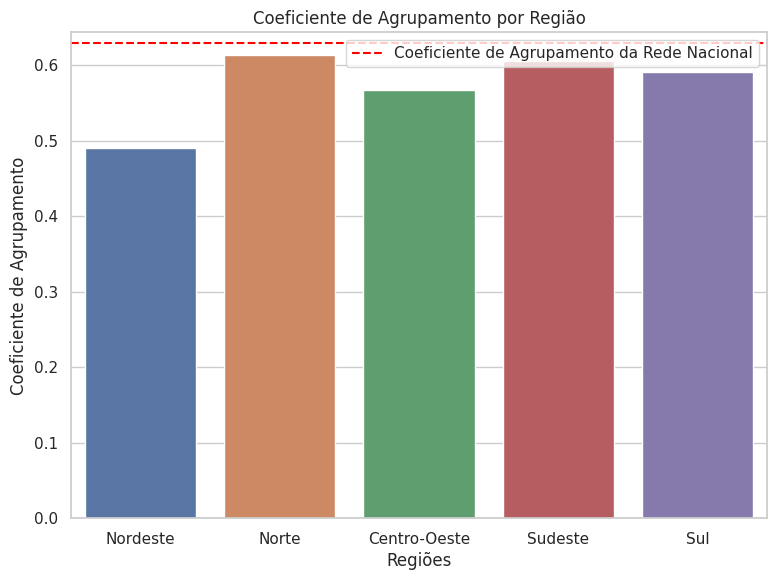


Coeficiente de Agrupamento da Rede Aérea Nacional: 0.6298820670024335
QTD de aeroportos -> topologia estrela: 81
------------------------------------
Coeficiente de Agrupamento da sub-Rede Nordeste: 0.4901000932205856
QTD de aeroportos -> topologia estrela: 31
------------------------------------
Coeficiente de Agrupamento da sub-rede Norte: 0.6129174483757457
QTD de aeroportos -> topologia estrela: 20
------------------------------------
Coeficiente de Agrupamento da sub-rede Centro-Oeste: 0.5665069530501541
QTD de aeroportos -> topologia estrela: 22
------------------------------------
Coeficiente de Agrupamento da sub-rede Sudeste: 0.6055274251271583
QTD de aeroportos -> topologia estrela: 25
------------------------------------
Coeficiente de Agrupamento da sub-rede Sul: 0.5907956617622271
QTD de aeroportos -> topologia estrela: 16
------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#from google.colab import data_table
#data_table.disable_dataframe_formatter()
#data_table.enable_dataframe_formatter()
import seaborn as sns

def topologiaZero (dicionario):

  aero_topzero = 0

  for chave in dicionario:
    if (dicionario[chave]) == 0:
      aero_topzero += 1
  return aero_topzero


#nx.clustering(subgraph)
#nx.average_clustering(subgraph)

# Lista com as regiões desejadas
regioes = ["NORDESTE", "NORTE", "CENTRO-OESTE", "SUL", "SUDESTE"]

# Filtra os nós com os atributos de região desejados
nodes_regioes = [node for node, region in G.nodes(data='region') if region in regioes]

# Cria um subgrafo com os nós selecionados
subgraph_nacional = G.subgraph(nodes_regioes)

# Cria o grafo geral
G = nx.read_graphml('/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/air_traffic.graphml')

# Filtra os nós com os atributos de região desejados
nodes_nordeste = [node for node, region in subgraph_nacional.nodes(data='region') if region == "NORDESTE"]
nodes_norte = [node for node, region in G.nodes(data='region') if region == "NORTE"]
nodes_centro_oeste = [node for node, region in G.nodes(data='region') if region == "CENTRO-OESTE"]
nodes_sudeste = [node for node, region in G.nodes(data='region') if region == "SUDESTE"]
nodes_sul = [node for node, region in G.nodes(data='region') if region == "SUL"]

# Cria um subgrafo com os nós selecionados
subgraph_nordeste = G.subgraph(nodes_nordeste)
subgraph_norte = G.subgraph(nodes_norte)
subgraph_centro_oeste = G.subgraph(nodes_centro_oeste)
subgraph_sudeste = G.subgraph(nodes_sudeste)
subgraph_sul = G.subgraph(nodes_sul)

#coeficeintes de agrupamento
CC_rede_nacional =  nx.average_clustering(subgraph_nacional)
CC_rede_nordeste =  nx.average_clustering(subgraph_nordeste)
CC_rede_norte =  nx.average_clustering(subgraph_norte)
CC_rede_centro_oeste =  nx.average_clustering(subgraph_centro_oeste)
CC_rede_sudeste =  nx.average_clustering(subgraph_sudeste)
CC_rede_sul =  nx.average_clustering(subgraph_sul)

lista_de_CC = [CC_rede_nordeste, CC_rede_norte, CC_rede_centro_oeste, CC_rede_sudeste, CC_rede_sul]

# Regiões
regioes = ['Nordeste', 'Norte','Centro-Oeste', 'Sudeste', 'Sul']

# Configuração do estilo estético
sns.set(style="whitegrid")

# Plotagem do gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=regioes, y=lista_de_CC, ax=ax)
plt.axhline(y=CC_rede_nacional, color='red', linestyle='--', label='Coeficiente de Agrupamento da Rede Nacional')

# Save figure
plt.savefig("/content/drive/MyDrive/UFRN/8º período/Estrutura de Dados II/data/imagens/grafico-de-coeficente-de-agrupamento.png", 
            format="png",
            dpi=400, 
            bbox_inches="tight",
            transparent=False)

# Configurações adicionais
plt.xlabel('Regiões')
plt.ylabel('Coeficiente de Agrupamento')
plt.title('Coeficiente de Agrupamento por Região')
plt.legend()

# Exibição do gráfico
plt.show()

dic_nacional = nx.clustering(subgraph_nacional)
dic_nordeste = nx.clustering(subgraph_nordeste)
dic_norte = nx.clustering(subgraph_norte)
dic_centro_oeste = nx.clustering(subgraph_centro_oeste)
dic_sudeste = nx.clustering(subgraph_sudeste)
dic_sul = nx.clustering(subgraph_sul)

#df = pd.DataFrame(dic_nordeste)

#v = (pd.DataFrame([dic_nordeste]))

print("\nCoeficiente de Agrupamento da Rede Aérea Nacional:", nx.average_clustering(subgraph_nacional))
print("QTD de aeroportos -> topologia estrela:", topologiaZero(dic_nacional))
print("------------------------------------")

print("Coeficiente de Agrupamento da sub-Rede Nordeste:", nx.average_clustering(subgraph_nordeste))
print("QTD de aeroportos -> topologia estrela:", topologiaZero(dic_nordeste))
print("------------------------------------")

print("Coeficiente de Agrupamento da sub-rede Norte:", nx.average_clustering(subgraph_norte))
print("QTD de aeroportos -> topologia estrela:", topologiaZero(dic_norte))
print("------------------------------------")

print("Coeficiente de Agrupamento da sub-rede Centro-Oeste:", nx.average_clustering(subgraph_centro_oeste))
print("QTD de aeroportos -> topologia estrela:", topologiaZero(dic_centro_oeste))
print("------------------------------------")

print("Coeficiente de Agrupamento da sub-rede Sudeste:", nx.average_clustering(subgraph_sudeste))
print("QTD de aeroportos -> topologia estrela:", topologiaZero(dic_sudeste))
print("------------------------------------")

print("Coeficiente de Agrupamento da sub-rede Sul:", nx.average_clustering(subgraph_sul))
print("QTD de aeroportos -> topologia estrela:", topologiaZero(dic_sul))
print("------------------------------------")

#data_table.DataTable(v, num_rows_per_page=5)

Calculamos o coeficiente de agrupamento para todos os casos (rede Aérea Nacional e as suas sub-redes) e imprimimos. Pudemos observar em todos os casos que o resultado indica uma rede mais conectada, mais distante da topologia em estrela. Também calculamos os casos em que o coeficiente deu exatamente 0, por cada região e na rede nacional, significando que em uma região tem um número x de aeroportos com topologia em estrela, ou seja, aeroportos com vizinhos sem outras conexões entre eles ou isolados. Um fato interessante: na rede nacional deu 81 casos com coeficiente 0, se somarmos os casos da sub-redes, o resultado não é o mesmo da rede nacional, pensamos que uma possível explicação para esse descobrimento é o fato de ao analisarmos as sub-redes, aquelas conexões em triângulo que existiam na "borda" deixam de existir, e por isso não é o mesmo ao somarmos.